# Final Project -Feature Engineering

## Feature Engineering

In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [7]:
labels=['viral_pneumonia', 'covid-19', 'bacterial_pneumonia', 'normal']

def load_data():
    X, y = [], []
    
    for label in labels:
        path=os.path.join('raw_data', label)
        files=os.listdir(path)
        print(label)
        
        for file_name in files:
            file_path = os.path.join(path, file_name)
            image = Image.open(file_path)
            image = image.resize((256, 256))
            image = image.convert('1')
            
            X.append(np.array(image))
            y.append(label)
    c = list(zip(X, y))
    np.random.shuffle(c)
    X, y = zip(*c)
    return np.array(X), np.array(y)

In [8]:
X, y = load_data();

viral_pneumonia
covid-19
bacterial_pneumonia
normal


In [10]:
dim=[image.ndim for image in X]
count=0
   
for i in dim:
    if i ==3:
        count+=1
print(count)
print(len(dim))
count/len(dim)*100

0
6662


0.0

In [12]:
size=[image.size for image in X]
count=0
index=0
index_list=[]

for i in size:
    if i== 65536:
        count+=1
        index+=1
        
    else:
        index+=1
        index_list.append(i)
        

print(count)
print(len(index_list))


6662
0


Text(0.5, 1.0, 'covid-19')

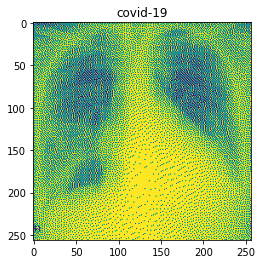

In [13]:
plt.imshow(X[300])
plt.title(y[300])

Text(0.5, 1.0, 'normal')

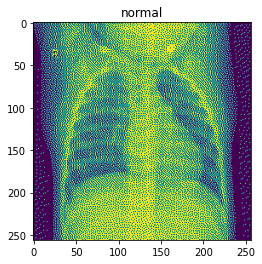

In [14]:
plt.imshow(X[-1])
plt.title(y[-1])

In [15]:
X.shape

(6662, 256, 256)